<div style="color:white;display:fill;border-radius:8px;
            background-color:#a7d5ed;font-size:170%;
            font-family:Nexa;letter-spacing:4.5px;">    
    <h1 style="padding:15px;color:black;text-align: center"> Ponto de partida (EDA) </h1> 
</div>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26480/logos/header.png?t=2021-04-09-00-57-05)

A edição agosto do <b>Tabular Playgroud Series de 2022</b> é  uma oportunidade para ajudar a empresa fictícia <b>Keep It Dry</b> a melhorar seu principal produto <b>Super Soaker</b>, o produto é usado em fábricas para absorver 

A empresa acaba de concluir um grande estudo de teste para diferentes protótipos de produtos,  podemos usar esses dados para construir um modelo que prevê falhas do produto? Esse é o grande desafio.  

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> OBJETIVO </h1>    
</div>

Neste notebook vamos fazer uma análise (EDA) para conhencer os dados e estabelecer uma linha de base, mostrarei as etapas iniciais de uma competição do Kaggle - desde a compreensão do conjunto de dados até a preparação dos dados para serem usados em um modelo machine learning. Vamos passar pelas seguintes tarefas:

- Leitura no conjunto de dados
- Calculando estatísticas sobre o conjunto de dados
- Visualização univariada
- Visualizando multivariada
- Pré-processamento 




---

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1. IMPORTAÇÕES </h1>    
</div>

## 1.1. Instalações

In [1]:
# https://pub.towardsai.net/use-google-colab-like-a-pro-39a97184358d
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    !pip install --q optbinning
    !pip install --q catboost
    !pip install --q pandas-profiling
    !pip install --q pycaret
        
    from google.colab import drive
    drive.mount('/content/drive')

## 1.2. Bibliotecas 

In [2]:
import warnings
import random
import os
import gc
import torch
import sklearn.exceptions
import datetime
#import shap

In [3]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import scipy.stats       as stats
import plotly.express    as px
import scikitplot        as skplt
import plotly.graph_objs as go

In [219]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, FunctionTransformer, MaxAbsScaler
from sklearn.preprocessing   import PowerTransformer, RobustScaler, Normalizer, PolynomialFeatures
from sklearn.preprocessing   import QuantileTransformer, LabelEncoder, OneHotEncoder
from sklearn.metrics         import roc_auc_score

In [196]:
from sklearn.compose           import ColumnTransformer, make_column_transformer
from sklearn.pipeline          import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute            import SimpleImputer

In [236]:
from lightgbm                   import LGBMClassifier
from sklearn.linear_model       import LogisticRegressionCV

---

## 1.3. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [107]:
class Ultil():
    
    import sklearn.exceptions
    
    def __init__(self):
        pass
    
    def jupyter_setting():
    
        %matplotlib inline

        #os.environ["WANDB_SILENT"] = "true" 
        #plt.style.use('bmh') 
        #plt.rcParams['figure.figsize'] = [20,15]
        #plt.rcParams['font.size']      = 13

        pd.options.display.max_columns = None
        #pd.set_option('display.expand_frame_repr', False)

        warnings.filterwarnings(action='ignore')
        warnings.simplefilter('ignore')
        warnings.filterwarnings('ignore')
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        warnings.filterwarnings('ignore', category=FutureWarning)
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
        warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)

        pd.set_option('display.max_rows', 200)
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.max_colwidth', None)

        icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
        #sns.palplot(sns.color_palette(icecream))

        colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
              "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
              "lightskyblue", "sandybrown", "yellowgreen", "indianred",
              "lightsteelblue", "mediumorchid", "deepskyblue"]

        # Colors
        dark_red   = "#b20710"
        black      = "#221f1f"
        green      = "#009473"
        myred      = '#CD5C5C'
        myblue     = '#6495ED'
        mygreen    = '#90EE90'    
        color_cols = [myred, myblue,mygreen]

        return icecream, colors, color_cols

    def missing_zero_values_table(df):
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()
    
    def reduce_memory_usage(df, verbose=True):
    
        numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
        start_mem = df.memory_usage().sum() / 1024 ** 2

        for col in df.columns:

            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == "int":
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024 ** 2
        if verbose:
            print(
                "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                    end_mem, 100 * (start_mem - end_mem) / start_mem
                )
            )

        return df
    
    def graf_label(ax, total):

         for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            width, height = i.get_width() -.2 , i.get_height()

            x, y  = i.get_xy()  
            color = 'white'
            alt   = .5
            soma  = 0 

            if height < 70:
                color = 'black'
                alt   = 1
                soma  = 10

            ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                        (i.get_x()+.3*width, 
                         i.get_y()+soma + alt*height),
                         color   = color,
                         weight = 'bold',
                         size   = 14)
            
    def graf_bar(df, col, title, xlabel, ylabel, tol = 0):
    
        #ax    = df.groupby(['churn_cat'])['churn_cat'].count()
        ax     = df    
        colors = col

        if tol == 0: 
            total  = sum(ax)
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           color   = colors, 
                           grid    = False)
        else:
            total  = tol     

            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           figsize = (10,6),
                           color   = colors,
                           grid    = False)

        #ax.yaxis.set_major_formatter(mtick.PercentFormatter())

        #y_fmt = tick.FormatStrFormatter('%.0f') 
        #ax.yaxis.set_major_formatter(y_fmt)

        title   = title #+ ' \n'
        xlabel  = '\n ' + xlabel 
        ylabel  = ylabel + ' \n'

        ax.set_title(title  , fontsize=22)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)    

        min = [0,23000000]
        #ax.set_ylim(min)

        Ultil.graf_label(ax, total)

    def correlation(df_, threshold_):
        col_corr    = set()  
        corr_matrix = df_.corr()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold_: 
                    colname = corr_matrix.columns[i]  
                    col_corr.add(colname)
                    
        return col_corr

    def graf_fature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                         print_graf_=True, mask_=True, title_=''):

        df = df_.copy().corr(method ='pearson').round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            # Making a plot
            ax = sns.heatmap(df, annot=annot_, 
                             mask=mask, 
                             cmap="RdBu", 
                             annot_kws={"weight": "bold", "fontsize":13}
                            )

            ax.set_title("\n Correlação das variável {} \n".format(title_), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                
    def describe(df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']

        return m

    def graf_outlier(df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                   (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

    def diff(t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

    def free_gpu_cache():

        # https://www.kaggle.com/getting-started/140636
        #print("Initial GPU Usage")
        #gpu_usage()                             

        #cuda.select_device(0)
        #cuda.close()
        #cuda.select_device(0)   

        gc.collect()
        torch.cuda.empty_cache()

    def graf_eval():

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#

            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))


            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();

    def linear_fit_slope(y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope

    def linear_fit_intercept(y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept

    def cromer_v(x, y):
        cm       = pd.crosstab(x, y).to_numpy()        
        n        = cm.sum()
        r, k     = cm.shape
        chi2     = stats.chi2_contingency(cm)[0]
        chi2corr = max(0, chi2 - (k-1) * (r-1) /(n-1))
        kcorr    = k - (k-1) **2/(n-1)
        rcorr    = r - (r-1) **2/(n-1)    
        v        = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))        
        return v  

    def generate_category_table(data):

        cols    = data.select_dtypes(include='object').columns
        dataset = pd.DataFrame()

        for i in cols:
            corr = []
            for x in cols: 
                corr.append(Ultil.cromer_v(data[i],data[x]))

            aux     = pd.DataFrame({i:corr})
            dataset = pd.concat([dataset, aux], axis=1) 

        return dataset.set_index(dataset.columns)
            
    def graf_feature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                          print_graf_=True, mask_=True, title_='', method_='pearson'):

        df = df_.corr(method=method_).round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            # Making a plot
            ax = sns.heatmap(df, annot = annot_, 
                             mask      = mask, 
                             cmap      = "RdBu", 
                             fmt       = ".2f",
                             annot_kws = {"weight": "bold", "fontsize":10}
                            )

            
            ax.set_title("\n Correlação das variável {} \n".format(title_), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                
        return Ultil.correlation(df_, threshold_)

    def plot_roc_curve(fpr, tpr, label=None):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "r-", label=label)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for FLAI 08')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.grid(True)

    def feature_engineering(df_):

        var_f27 = ''
        for col in df_['f_27']: 
            var_f27 +=col

        var_f27 = list(set(var_f27))
        var_f27.sort()

        df_["fe_f_27_unique"] = df_["f_27"].apply(lambda x: len(set(x)))

        for letra in var_f27:             
            df_['fe_' + letra.lower() + '_count'] = df2_train["f_27"].str.count(letra)

        return df_ 

    def identifies_outliers(df):

        cols_num = df.select_dtypes(np.number).columns

        for col in cols_num: 
            if col != 'unnamed':            
                Q1  = df[col].quantile(0.25)
                Q3  = df[col].quantile(0.75)
                IQR = Q3-Q1
                lowqe_bound=Q1 - 1.5 * IQR
                upper_bound=Q3 + 1.5 * IQR

                df['outliers_'+ col] = 0
                df['outliers_'+ col][(df[col]<=lowqe_bound)|(df[col]>=upper_bound)] = 1    

                df[col] = np.where(df[col] > df[col].quantile(0.95),
                                                df[col].median(),
                                                df[col])

    def evaluation(y_, predictions_):
        mae  = metrics.mean_absolute_error(y_, predictions_)
        mse  = metrics.mean_squared_error(y_, predictions_)
        rmse = metrics.mean_squared_error(y_, predictions_, squared=False) 
        mape = metrics.mean_absolute_percentage_error(y_, predictions_)
        r2   = metrics.r2_score(y_, predictions_)    
        return rmse, mae, mse, mape, r2
    
    def feature_statistic(df, feature_float, feature_cat=None):
        df['fe_mean']        = df[feature_float].mean(axis=1)   
        df['fe_std']         = df[feature_float].std(axis=1)   
        df['fe_median']      = df[feature_float].median(axis=1)   
        df['fe_var']         = df[feature_float].var(axis=1) 
        df['fe_min']         = df[feature_float].min(axis=1)   
        df['fe_max']         = df[feature_float].max(axis=1)   
        df['fe_skew']        = df[feature_float].skew(axis=1)   
        df['fe_quantile_25'] = df[feature_float].quantile(q=.25, axis=1)
        df['fe_quantile_50'] = df[feature_float].quantile(q=.5, axis=1)
        df['fe_quantile_75'] = df[feature_float].quantile(q=.75, axis=1)
        
        if feature_cat is not None:
            df['fe_dammy_count'] = df[feature_cat].sum(axis=1)   
        
        return df

In [7]:
icecream, colors, color_cols = Ultil.jupyter_setting()

---

## 1.4. Dataset

### 1.4.1. Descrição de dados

Os para essa competição representam os resultados de um grande estudo de teste de produtos. Para cada product_code recebemo um número de produtos attributes(fixo para o código), bem como uma série de measurement valores para cada produto individual, representando vários métodos de teste de laboratório. Cada produto é usado em um experimento simulado de ambiente do mundo real e absorve uma certa quantidade de fluido (loading) para ver se falha ou não.

Nossa tarefa é usar os dados para prever falhas de novos códigos de produtos individuais com seus resultados de testes de laboratório individuais. 


### 1.4.2. Arquivos 
- <b>train.csv</b> - os dados de treinamento, que incluem a variável alvo(failure);
- <b>test.csv</b> - o conjunto de teste; a tarefa é prever a probabilidade de uma falha;
- <b>sample_submission.csv</b> - um arquivo de envio de amostra no formato correto

### 1.4.3. Estrutura de pasta
A finalidade é criar um estrutura de pasta para armazenar os artefatos criados no processo de análise e modelagem.

In [121]:
path        = '/content/drive/MyDrive/Flai/09/' if COLAB else ''   
path_data   = 'Data/'  
path_automl = 'automl/'
target      = 'failure'

In [16]:
paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
         'model', 'model/preds', 'model/optuna','model/preds/test', 'Data/shap',
         'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
         'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
         'model/preds/train/n3', 'model/preds/param', 'model/mdl', 'model/preds/folds' ]

for p in paths:
    try:
        os.mkdir(path + p)       
    except:
        pass 

### 1.4.4. Carrega dados

In [17]:
df1_train     = pd.read_csv(path + path_data + 'train.csv')
df1_test      = pd.read_csv(path + path_data + 'test.csv')
df_submission = pd.read_csv(path + path_data + 'sample_submission.csv')

df1_train.shape,  df_submission.shape

((26570, 26), (20775, 2))

In [18]:
df1_train.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


---

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2. Análise Exploratória de Dados (EDA) </h1>    
</div>

Antes de trabalhar com qualquer tipo de dados é importante entendê-los. Um passo crucial para esse objetivo é a Análise Exploratória de Dados (EDA): uma combinação de visualizações e análise estatística (uni, bi e multivariada) que nos ajude a entender melhor os dados com os quais estamos trabalhando e obter insights sobre seus relacionamentos.


In [127]:
df2_train = df1_train.copy()
df2_test  = df1_test.copy()

## 2.1. Dimensão do DataSet

In [22]:
print('TREINO')
print('Numero de linhas : {}'.format(df2_train.shape[0]))
print('Numero de colunas: {}'.format(df2_train.shape[1]), end='\n\n')

TREINO
Numero de linhas : 26570
Numero de colunas: 26



---

## 2.2. Tipo de dados

In [23]:
df2_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26570 entries, 0 to 26569
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              26570 non-null  int64  
 1   product_code    26570 non-null  object 
 2   loading         26320 non-null  float64
 3   attribute_0     26570 non-null  object 
 4   attribute_1     26570 non-null  object 
 5   attribute_2     26570 non-null  int64  
 6   attribute_3     26570 non-null  int64  
 7   measurement_0   26570 non-null  int64  
 8   measurement_1   26570 non-null  int64  
 9   measurement_2   26570 non-null  int64  
 10  measurement_3   26189 non-null  float64
 11  measurement_4   26032 non-null  float64
 12  measurement_5   25894 non-null  float64
 13  measurement_6   25774 non-null  float64
 14  measurement_7   25633 non-null  float64
 15  measurement_8   25522 non-null  float64
 16  measurement_9   25343 non-null  float64
 17  measurement_10  25270 non-null 

In [24]:
print(f'{3*"="} For Pandas {10*"="}\n{(df2_train.dtypes).value_counts()}')

=== For Pandas ==========
float64    16
int64       7
object      3
dtype: int64


In [25]:
feature_float = df2_train.select_dtypes(np.float64).columns.to_list() 
feature_int   = df2_train.select_dtypes(np.int64).columns.to_list() 
feature_int.remove('id')

Vamos dar uma olhada nas variáveis do tipo int64.  

In [26]:
for col in df2_train[feature_int]:   
    num = df2_train[col].unique().tolist()
    num.sort()
    print('-'* 70)
    print('{} unique: {}'.format(col, num))    
    print('-'* 70)
    print()

----------------------------------------------------------------------
attribute_2 unique: [5, 6, 8, 9]
----------------------------------------------------------------------

----------------------------------------------------------------------
attribute_3 unique: [5, 6, 8, 9]
----------------------------------------------------------------------

----------------------------------------------------------------------
measurement_0 unique: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29]
----------------------------------------------------------------------

----------------------------------------------------------------------
measurement_1 unique: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
----------------------------------------------------------------------

----------------------------------------------------------------------
measurement_2 unique: [0, 1, 

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Podemos observar que as variáveis: <b>measurement_0, measurement_1 e measurement_2</b> seguem um ordem em relação as outras measurements, pode ser um indicativo que essas variáveis foram transformadas em ordinal no processo de geração dos datasets, sendo assim, temos que utilzar normalizador que não altere essa ordem, isso pode ser um diferencial para a modelagem. <p><br>
    
</div>

---

## 2.3. Identificar NA

In [27]:
missing = Ultil.missing_zero_values_table(df2_train)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 26 colunas e 26570 linhas. 
Existem 16 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados
0,measurement_17,2284,8.600000,float64
1,measurement_16,2110,7.940000,float64
2,measurement_15,2009,7.560000,float64
3,measurement_14,1874,7.050000,float64
4,measurement_13,1774,6.680000,float64
5,measurement_12,1601,6.030000,float64
6,measurement_11,1468,5.530000,float64
7,measurement_10,1300,4.890000,float64
8,measurement_9,1227,4.620000,float64
9,measurement_8,1048,3.940000,float64


<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Como podemos observar acima, o percentual de dados faltantes das variáveis é baixo, neste casso no primeiro momento vamos fazer a inputação da mediana para o modelo de linha de base. <p><br>
    
</div>

In [46]:
duplicates = df2_train['id'].duplicated().sum()
print('Duplicates in data: {0}'.format(duplicates))

Duplicates in data: 0


## 2.4 Estatística Descritiva
Abaixo estão as estatísticas básicas para cada variável que contém informações sobre contagem, média, desvio padrão, mínimo, 1º quartil, mediana, 3º quartil e máximo.

### 2.4.1. Descritivo

In [47]:
df2_train.drop('id', axis=1).describe().T.style.background_gradient(cmap='YlOrRd')

,count,mean,std,min,25%,50%,75%,max
loading,26320.000000,127.826233,39.030020,33.160000,99.987500,122.390000,149.152500,385.860000
attribute_2,26570.000000,6.754046,1.471852,5.000000,6.000000,6.000000,8.000000,9.000000
attribute_3,26570.000000,7.240459,1.456493,5.000000,6.000000,8.000000,8.000000,9.000000
measurement_0,26570.000000,7.415883,4.116690,0.000000,4.000000,7.000000,10.000000,29.000000
measurement_1,26570.000000,8.232518,4.199401,0.000000,5.000000,8.000000,11.000000,29.000000
measurement_2,26570.000000,6.256568,3.309109,0.000000,4.000000,6.000000,8.000000,24.000000
measurement_3,26189.000000,17.791528,1.001200,13.968000,17.117000,17.787000,18.469000,21.499000
measurement_4,26032.000000,11.731988,0.996085,8.008000,11.051000,11.733000,12.410000,16.484000
measurement_5,25894.000000,17.127804,0.996414,12.073000,16.443000,17.132000,17.805000,21.425000
measurement_6,25774.000000,17.510759,0.995980,12.715000,16.839000,17.516000,18.178000,21.543000


<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

As variáveis que mais me chamaram a atenção são <b>measurement_17 e loading</b> com média e desvio padrão muito alto em relação as outras variáveis. <p> <br>
    
</div>

### 2.4.2. Gráfico de Variância

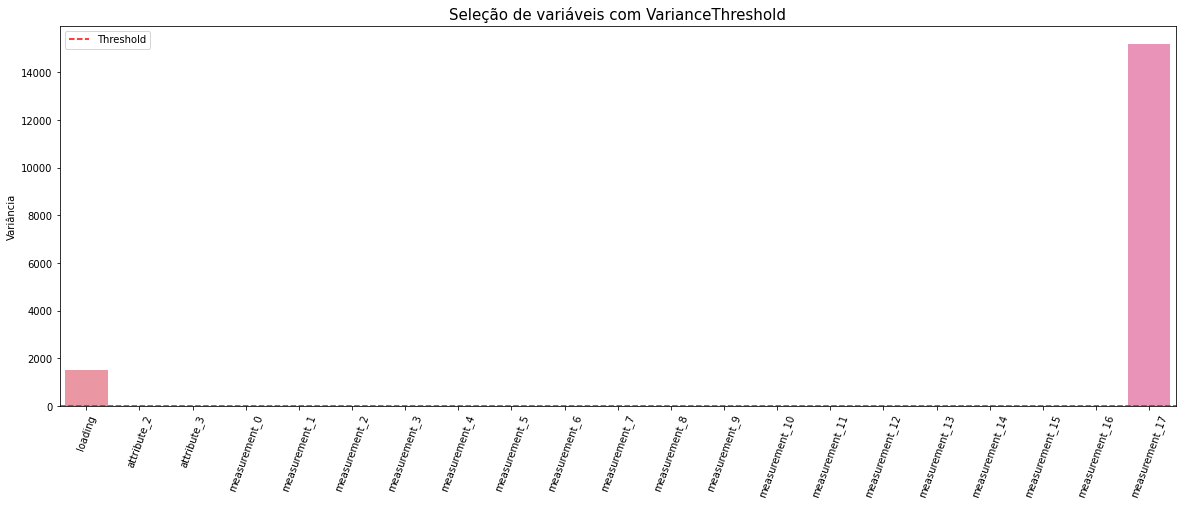

In [80]:
threshold = 2.2
selector  = VarianceThreshold(threshold=threshold)
df_aux    = df2_train.select_dtypes(np.number).drop(['id','failure'], axis=1)
selector.fit_transform(df_aux)

plt.figure(figsize=(20,7))
sns.barplot(y=selector.variances_, x=df_aux.columns, orient='v')
plt.title('Seleção de variáveis com VarianceThreshold',size=15);
plt.ylabel('Variância');
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xticks(rotation=70)
plt.legend();

del df_aux

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Acima observamos duas variáveis se destacando com alta variância, vamos verificar a variância por tipo de variáveis: <p> <br>
    
</div>

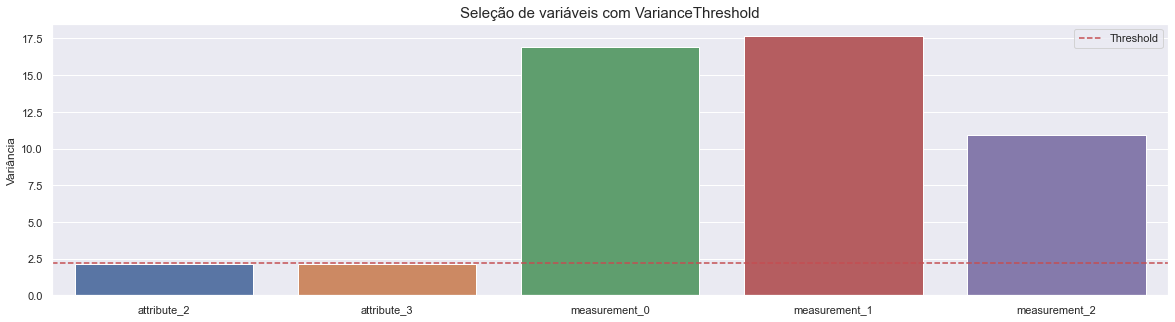

In [90]:
threshold = 2.2
selector  = VarianceThreshold(threshold=threshold)
df_aux    = df2_train.select_dtypes(np.int).drop(['id','failure'], axis=1)
selector.fit_transform(df_aux)

plt.figure(figsize=(20,5))
sns.barplot(y=selector.variances_, x=df_aux.columns, orient='v')
plt.title('Seleção de variáveis com VarianceThreshold',size=15);

plt.ylabel('Variância');
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend();

del df_aux

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Por tipo de variável, neste caso int,  emos uma melhor visualização e entendimento da variância, temos três variáveis com alta variância, sendo que duas se destacam: <b>measurement_0 e measurement_1<b> e duas com baixa variância: <b> attribute_2 e attribute_3</b>.   
    
</div>

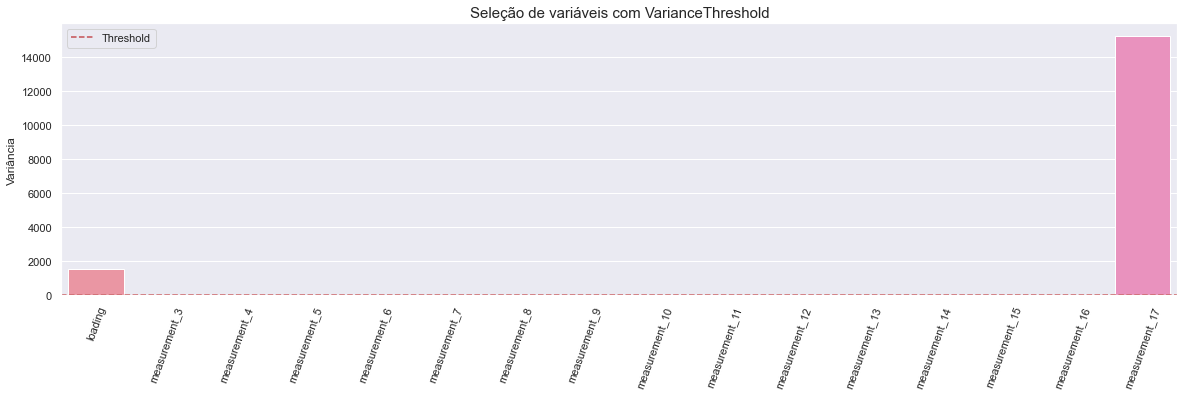

In [91]:
threshold = 2.5
selector  = VarianceThreshold(threshold=threshold)
df_aux    = df2_train.select_dtypes(np.float64)
selector.fit_transform(df_aux)

plt.figure(figsize=(20,5))
sns.barplot(y=selector.variances_, x=df_aux.columns, orient='v')

plt.xticks(rotation=70)
plt.title('Seleção de variáveis com VarianceThreshold',size=15);
plt.ylabel('Variância')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()

del df_aux;

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

As variáveis <b>loading e measurement_1</b> se destacam em relação as outras variáveis, vamos excluí-las do gráfico para termos um melhor entendimento das outras variáveis.  
    
</div>

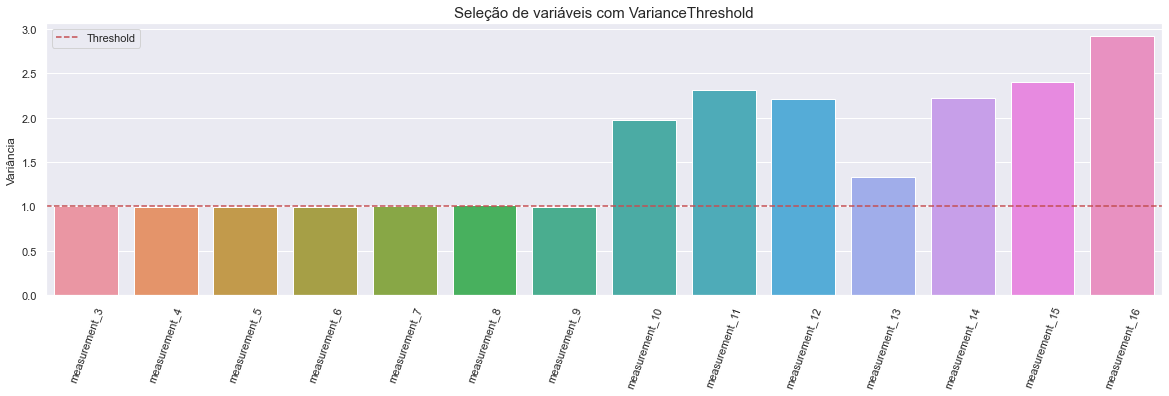

In [92]:

threshold = 1
selector  = VarianceThreshold(threshold=threshold)
df_aux    = df2_train.select_dtypes(np.float64).drop(['measurement_17', 'loading'], axis=1)
selector.fit_transform(df_aux)

plt.figure(figsize=(20,5))
sns.barplot(y=selector.variances_, x=df_aux.columns, orient='v')

plt.xticks(rotation=70)
plt.title('Seleção de variáveis com VarianceThreshold',size=15);
plt.ylabel('Variância')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()

del df_aux;

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Agora temos um melhor entendimento da variância com os gráficos acima, podemos destacar:  
- Entre as variávies do inteiro temos duas com alta variância e duas com baixa variância, a terceira (<b> measurement_2</b>) pode ser uma variável segnificativa na modelagem; <p>
    
- A <b>loading e measurement_1</b> são as variáveis que tem maior variância entre as variáveis continuas; <p>
    
- As variáveis entre <b>measurement_1 até a measurement_9</b> tem baixa variância entre as variáveis continuas, provavelmente não são relevantes para modelagem. 
    
    
<p> <br>
    
    
</div>

---

## 2.5. Distribuição

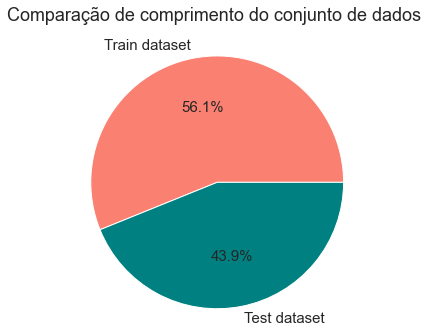

In [94]:
fig, ax = plt.subplots(figsize=(5, 5))

pie = ax.pie([len(df1_train), len(df1_test)],
             labels   = ["Train dataset", "Test dataset"],
             colors   = ["salmon", "teal"],
             textprops= {"fontsize": 15},
             autopct  = '%1.1f%%')

ax.axis("equal")
ax.set_title("Comparação de comprimento do conjunto de dados \n", fontsize=18)
fig.set_facecolor('white')
plt.show();

### 2.5.1. Distribuição Train x Test

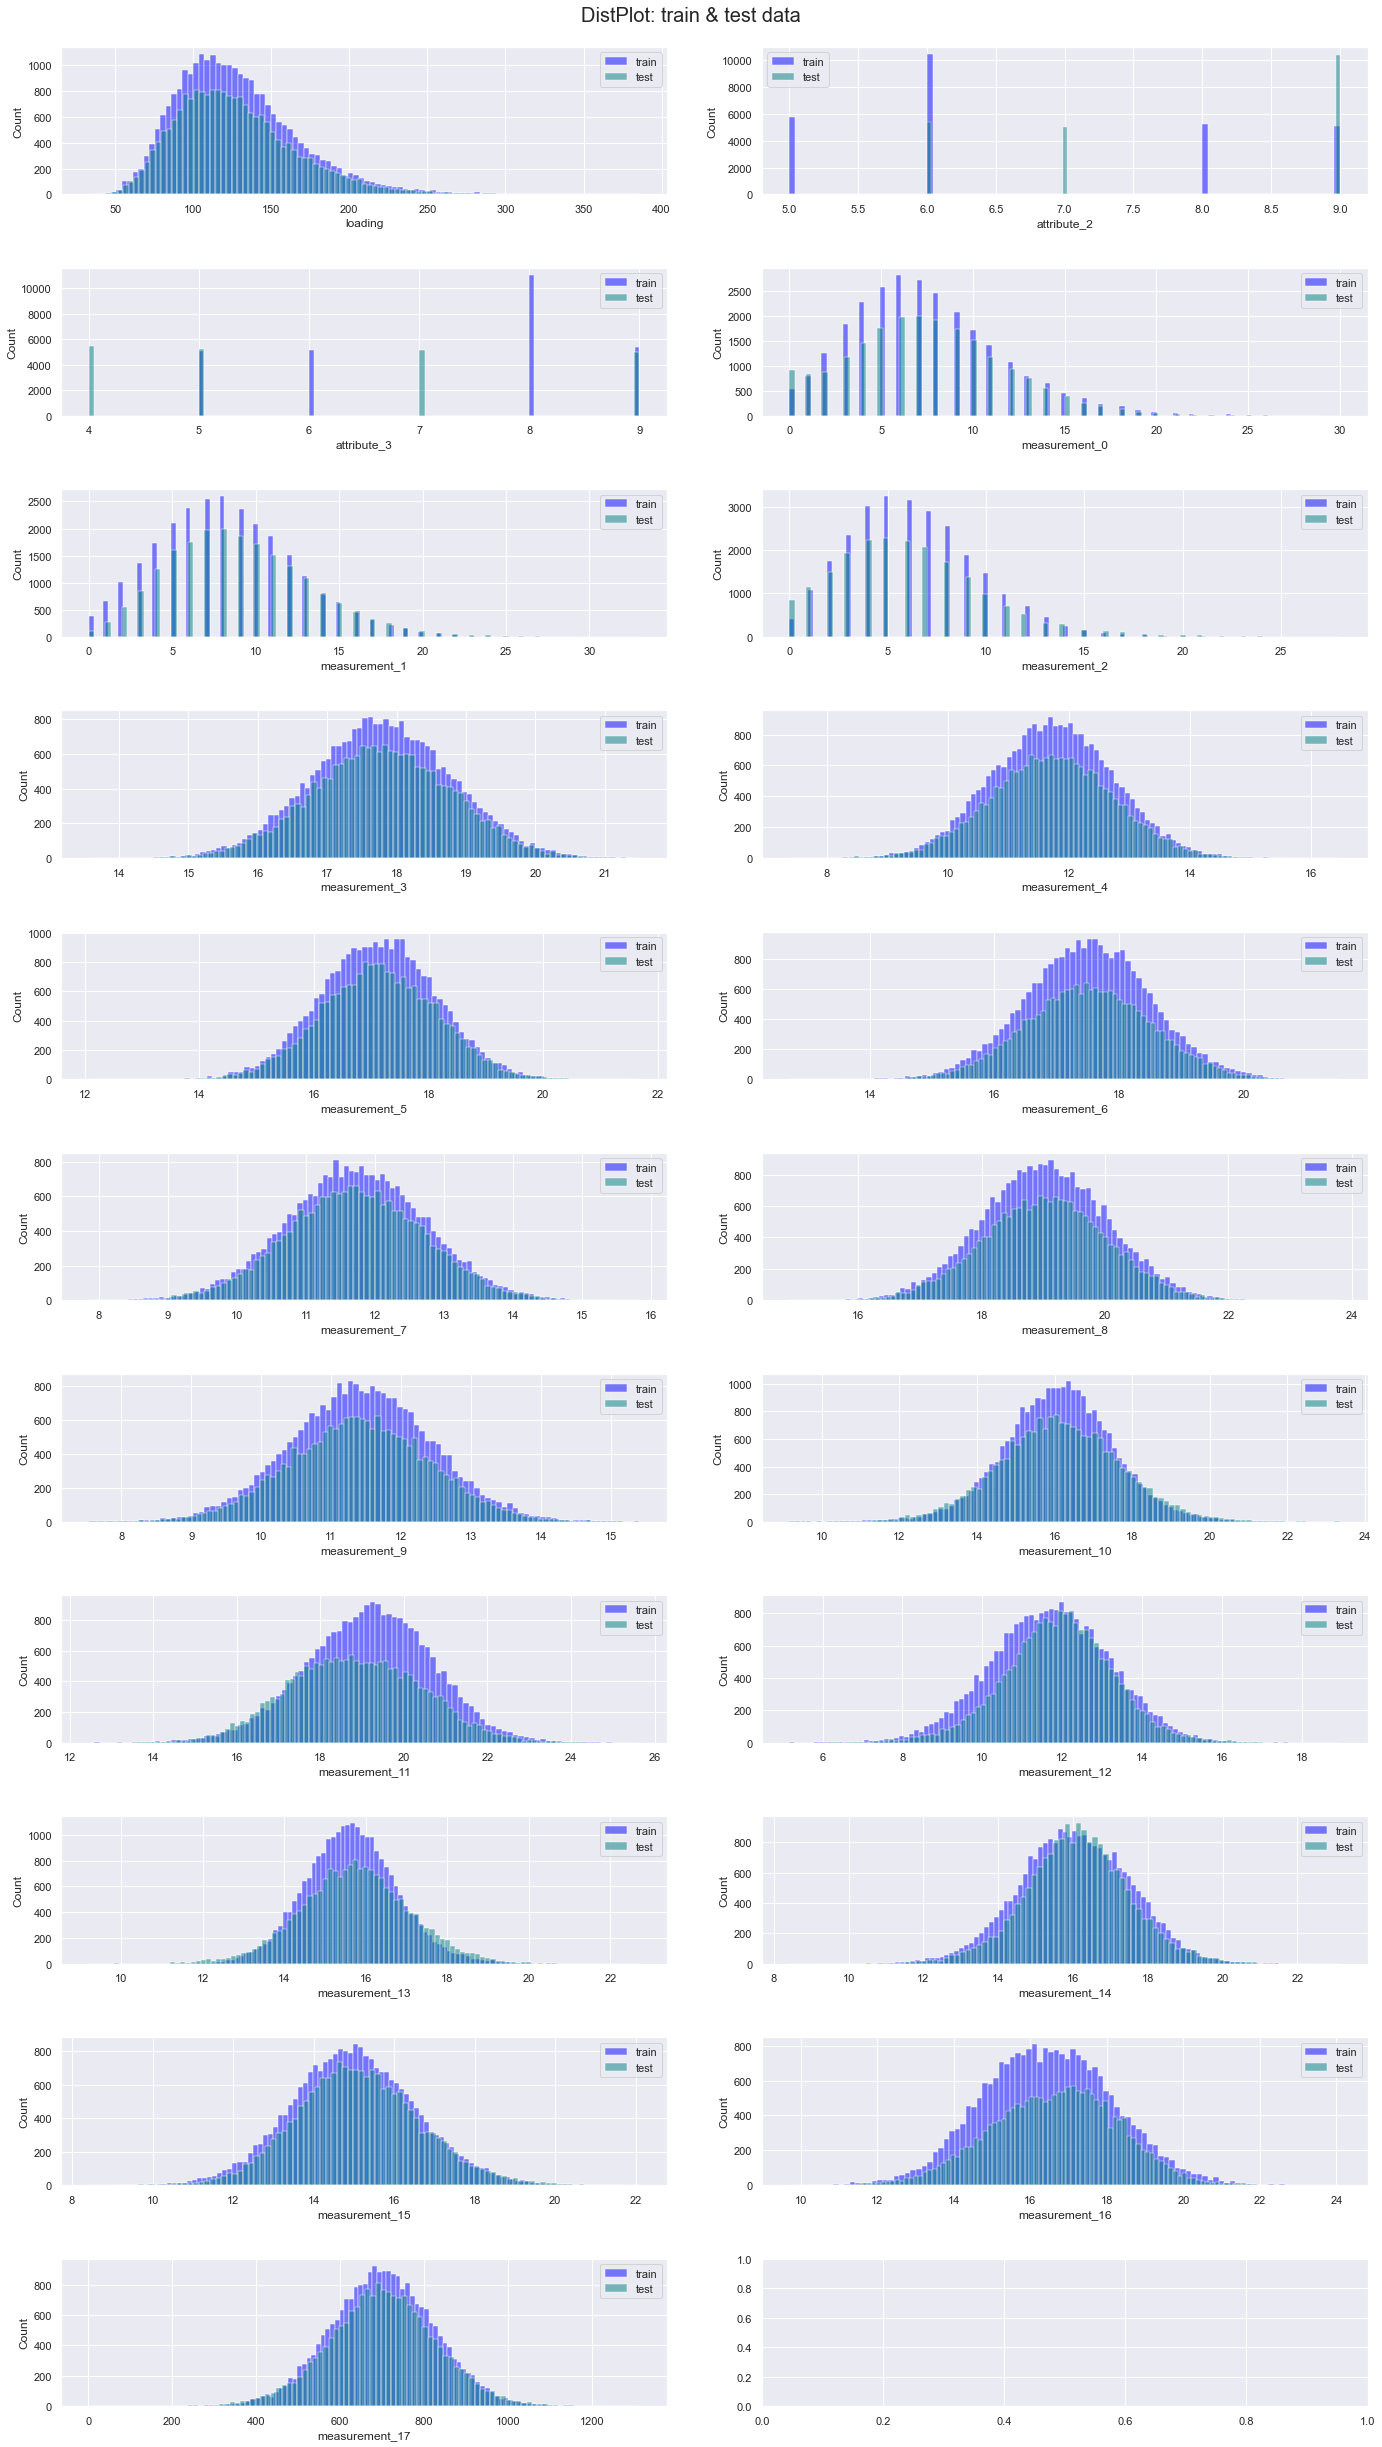

In [136]:
feature_float = df2_test.drop('id', axis=1).select_dtypes(np.number).columns.to_list()


lines   = int(len(feature_float)/2)+1
fig, ax = plt.subplots(lines,2 ,figsize=(20,35))

for i,feature in enumerate(feature_float):
    plt.subplot(lines,2,i+1)
    sns.histplot(data=df2_train, x=df2_train[feature],color='blue', alpha=0.5, label='train', bins=100)
    sns.histplot(data=df2_test , x=df2_test[feature] ,color='teal', alpha=0.5, label='test' , bins=100)     
    plt.xlabel(feature, fontsize=12)
    plt.legend()
         
plt.suptitle('DistPlot: train & test data', fontsize=20)
plt.tight_layout(pad=3.0);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Ambos os datasets seguem a mesma distribuição.
    
</div>

### 2.5.2. Proporção de variáveis

In [ ]:
feature_cat   = df2_train.drop(['id', 'failure', 'attribute_1', 'attribute_2'], axis=1)  \
                .select_dtypes(int).columns.to_list()
feature_float = df2_train.select_dtypes(np.float64).columns.to_list()

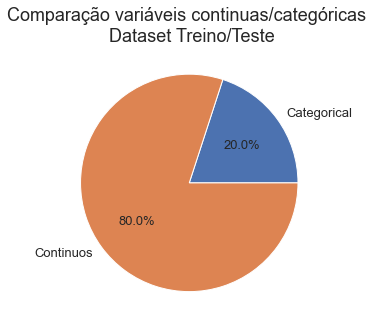

In [102]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.pie([ len(feature_cat), len(feature_float)], 
        labels=['Categorical', 'Continuos' ],
        textprops={'fontsize': 13},
        autopct='%1.1f%%')

#ax.axis("equal")
ax.set_title("Comparação variáveis continuas/categóricas \n Dataset Treino/Teste", fontsize=18)
fig.set_facecolor('white')
plt.show()

### 2.5.3. Variável predidora

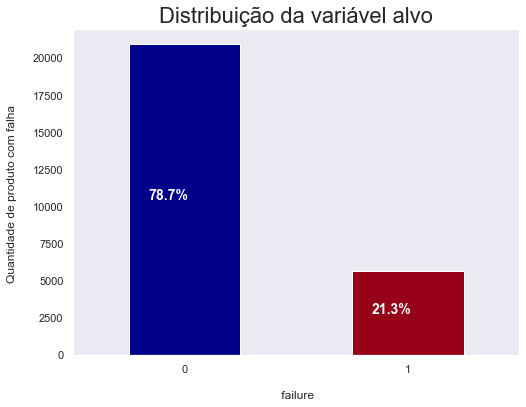

In [117]:
plt.figure(figsize=(8,6))  
Ultil.graf_bar(df2_train.groupby(['failure'])['failure'].count(), 
               icecream, 'Distribuição da variável alvo', 'failure', 
               'Quantidade de produto com falha');

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Observamos no gráfico acima o desbalanceamento da variável alvo, teste de balanceamento podem ser uma solução para ajuda na modelagem. <p> <br>
    
    
</div>

## 2.6. Dados Númericos

### 2.6.1. Correlação

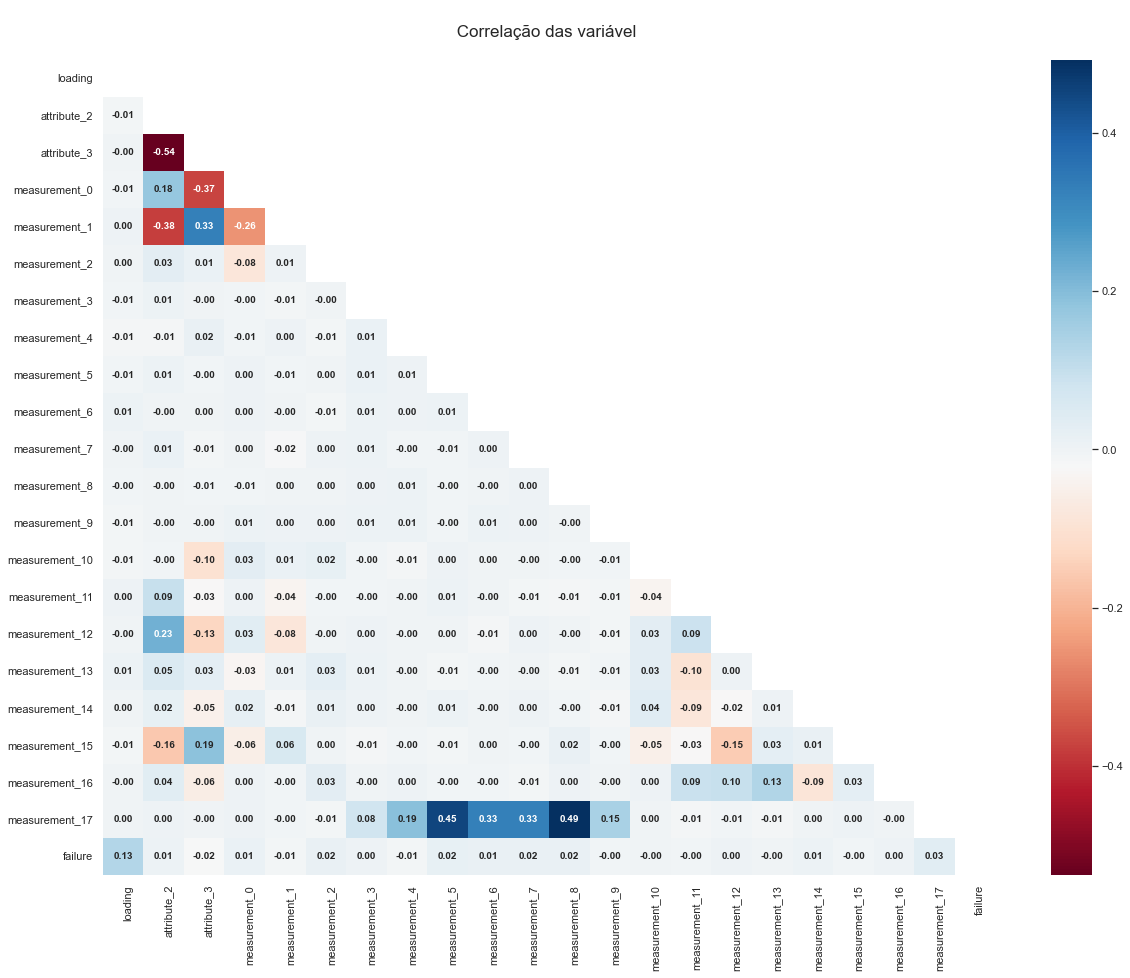

In [118]:
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(20,15))

feature_corr = \
    Ultil.graf_feature_corr(df_         = df2_train.drop('id', axis=1).copy(), 
                            annot_      = True, 
                            threshold_  = .1, 
                            print_var_  = False, 
                            print_graf_ = True, 
                            mask_       = True);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Não temos autocorrelação entre as variáveis, principalmete com a variável alvo que é muito baixa, a variável com maior correlação é <b>loading</b> com 0.13. Nesta competição quem tive aptidão de criar novas variáveis com relevância será o diferêncial. <p> <br>
    
    
</div>

### 2.5.2. Histograma

Vamos plotar apenas as variáveis float. 

In [119]:
sns.set(style="darkgrid")

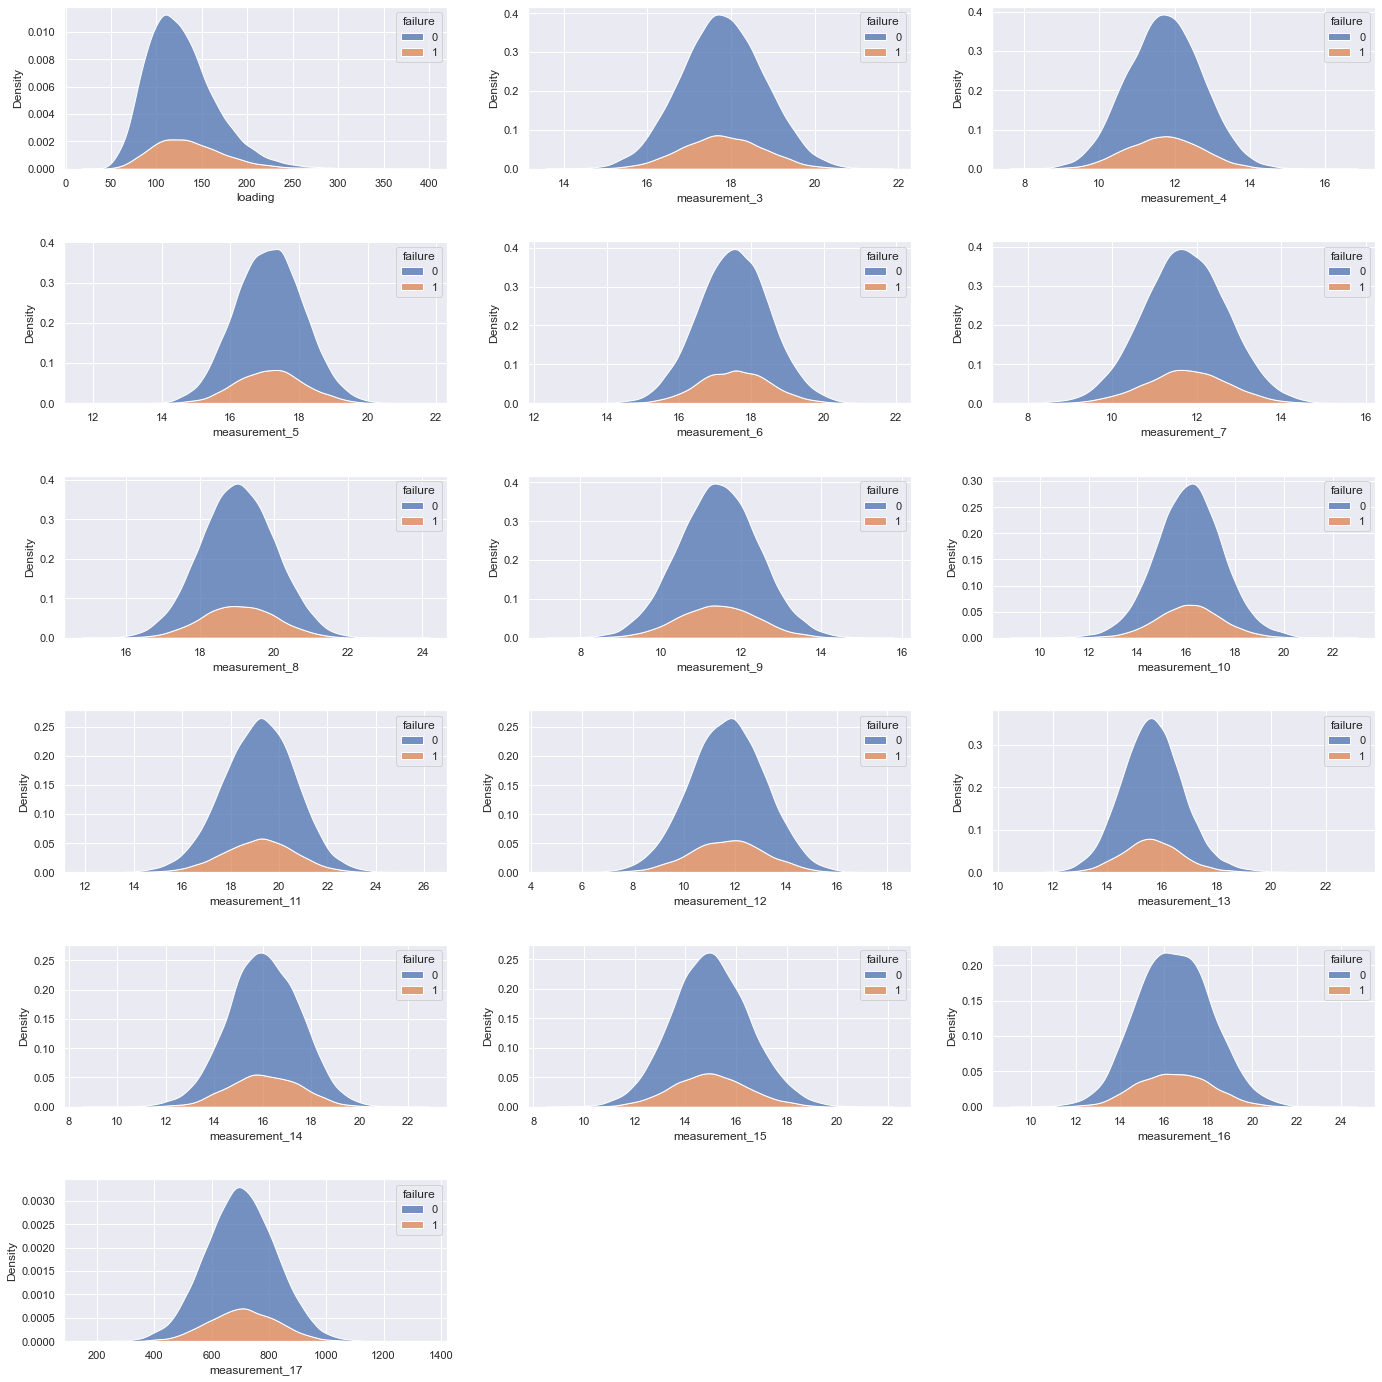

In [124]:
plt.subplots(figsize=(20, 20))

for i, col in enumerate(feature_float):    
    plt.subplot(int(len(feature_float)/3 +1),3,i+1)
    sns.kdeplot(data=df2_train, x=col, hue=target, legend=True, shade=True, multiple='stack');
    
plt.tight_layout(pad=3.0)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
   <p> <br>
    
</div>

### 2.5.3. Outliers

In [138]:
def iqr_outliers(df,ft):
    
    q1  = df[ft].quantile(0.25)
    q3  = df[ft].quantile(0.75)
    iqr = q3-q1
    c   = 0 
    
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    
    for i in range(len(df[ft])):
        if df[ft][i] > Upper_tail or df[ft][i] < Lower_tail:
            c+=1
    return c

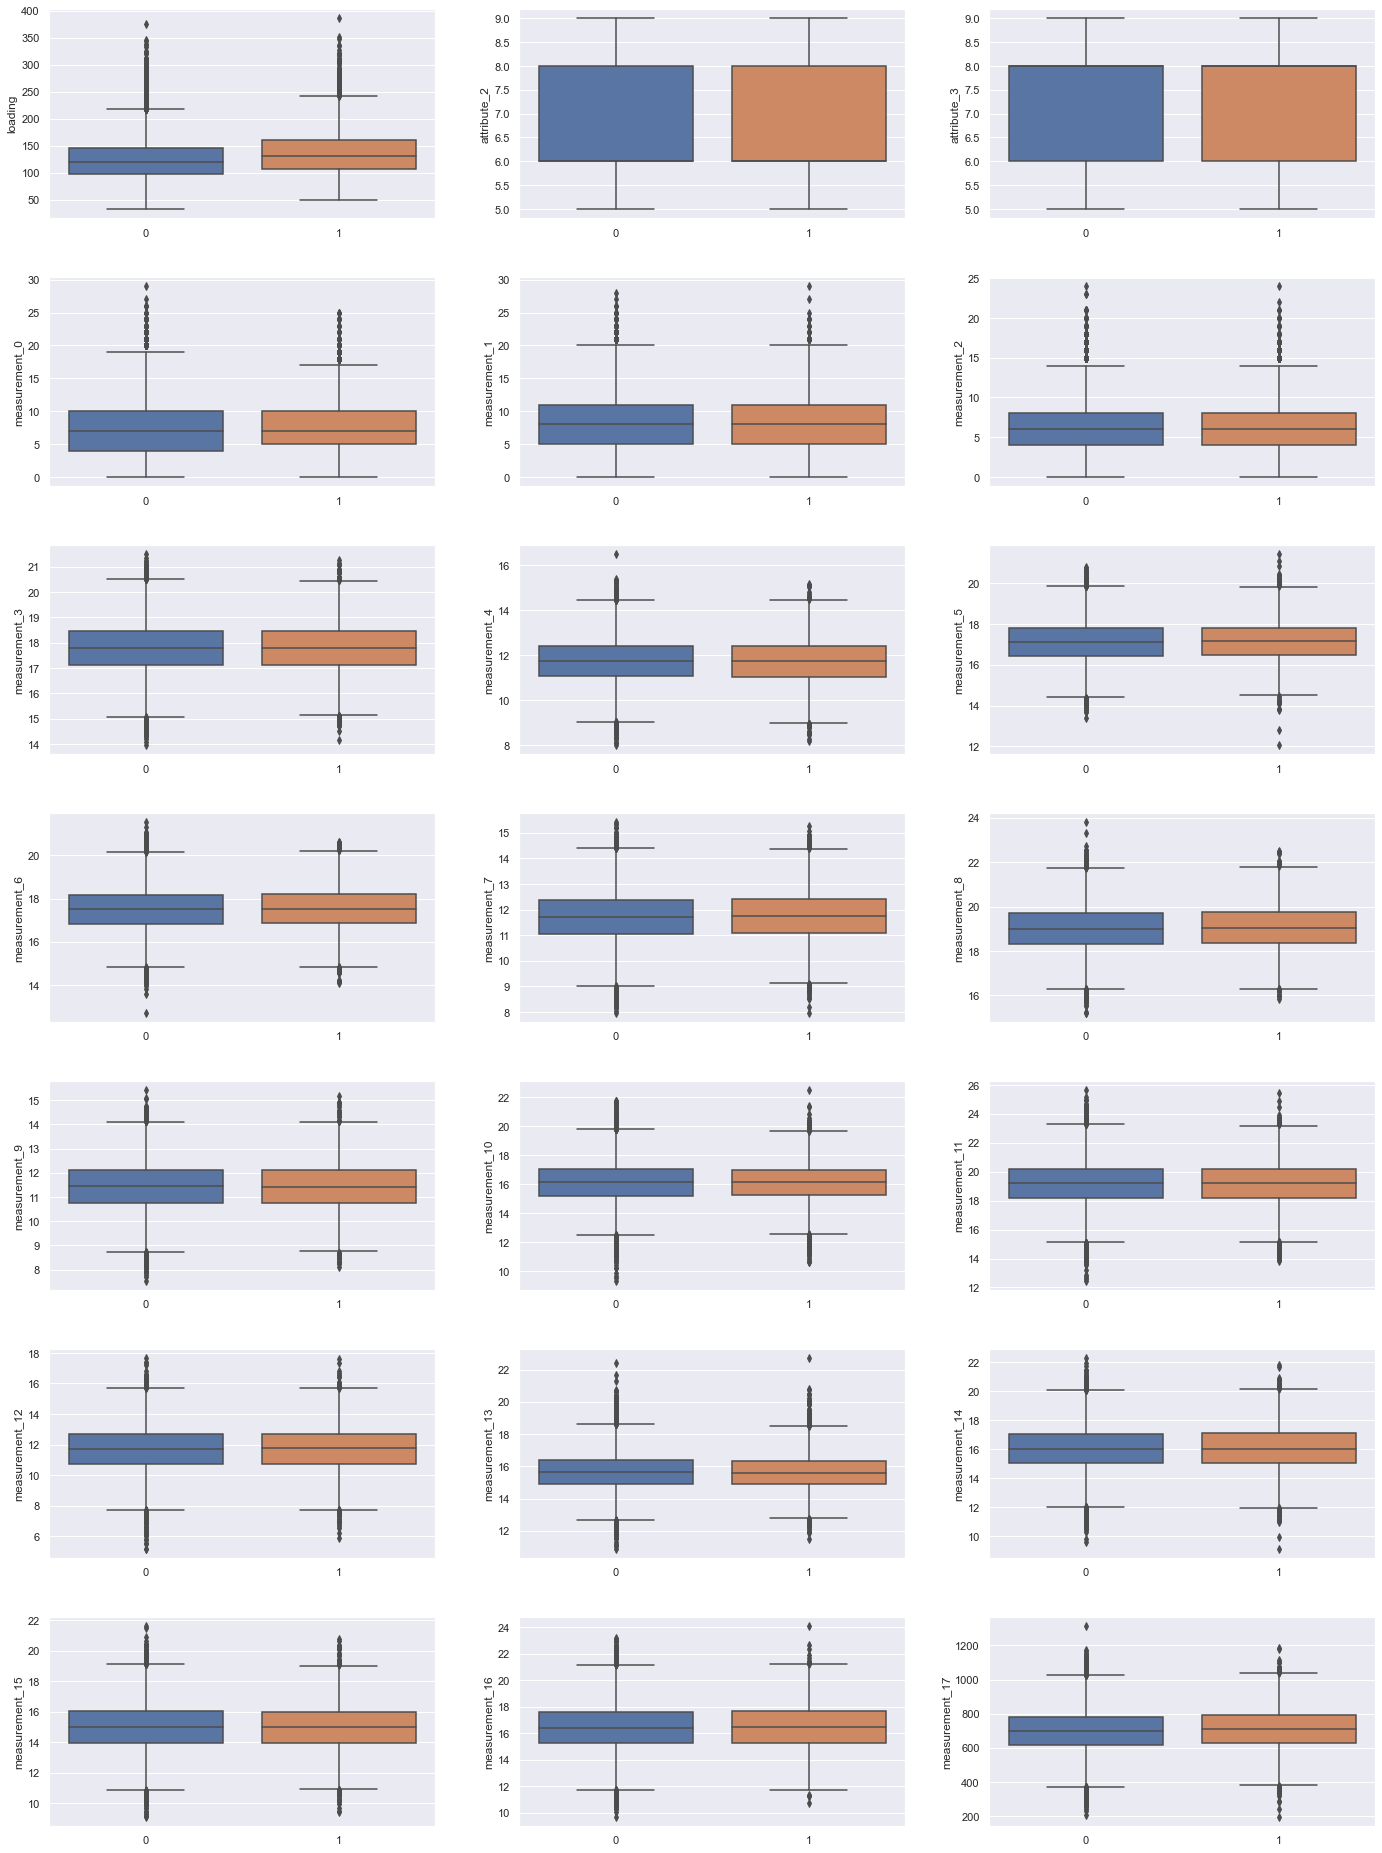

In [144]:
f, ax   = plt.subplots(figsize=(20, 30))
feature = df2_train.select_dtypes(np.number).columns.drop(['id', target]).to_list() 
row     = int(len(feature)/3 +1)

for i, col in enumerate(feature): 
    plt.subplot(row, 3, i+1)
    sns.boxplot(data=df2_train, y=col, x=target) 
    plt.xlabel('')
    
plt.tight_layout(pad=3.0)

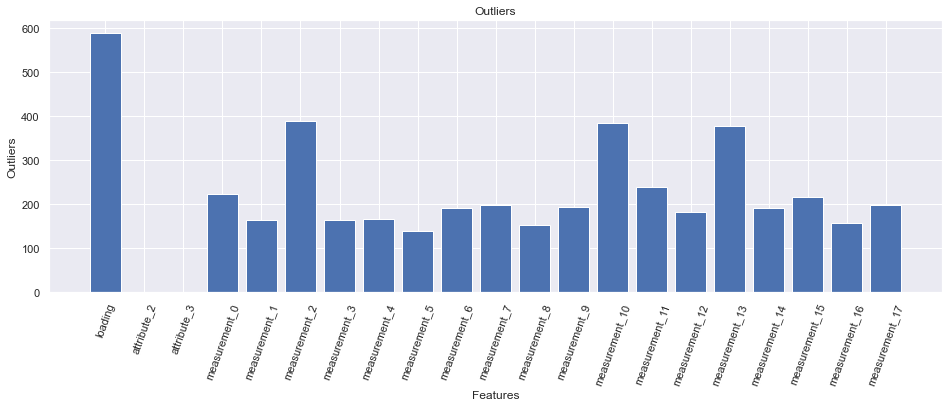

In [146]:
out = []
od  = {f:iqr_outliers(df2_train,f) for f in feature}

# Plotting Outliers
plt.figure(figsize=(16,5))
plt.bar(x=od.keys(),height=od.values())
plt.xlabel("Features")
plt.ylabel("Outliers")
plt.title('Outliers')
plt.xticks(rotation=70)
plt.show()

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
  
- Todas as variáveis tem outliers, talvez a criação de uma variável que indique que aquele dados (amostra) é um outlier pode ajudar na modelagem, podemos utilizar o intervalo interquartil para identificar os outliers e criar a nova variável; <p>
    
- A variável <b>loading</b> se destaca com maior número de outliers, seguidas das variáveis <b>measurements_0, measurements_10 e measurements_13.</b>.<p> <br>
    
    
</div>

### 2.8.4. Variáveis discretas

In [178]:
feature = feature_int.copy()
feature.append('attribute_1')
feature.append('product_code')
feature.remove(target)
feature.sort()

feature.append(target)

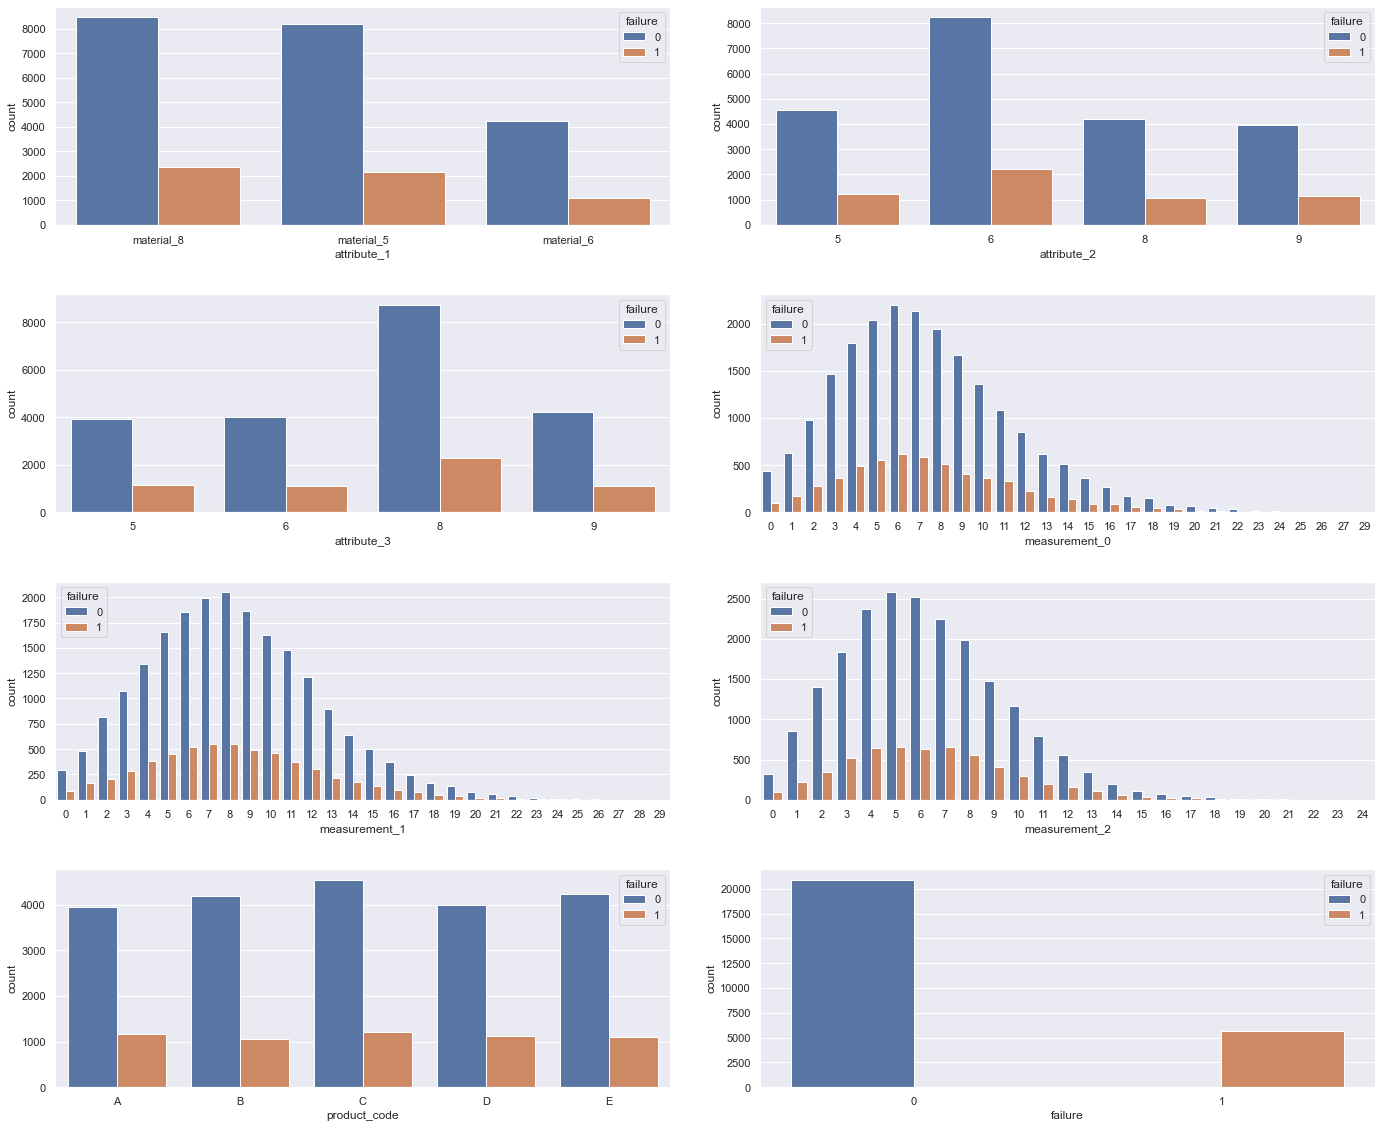

In [179]:
plt.figure(figsize=(20,20))

row = int(len(feature)/2)+1

for i, col in enumerate(feature):
    plt.subplot(row, 2, i+1)
    ax = sns.countplot(data=df2_train, x=col, hue=target)  
    
plt.tight_layout(pad=3.0)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
  
Podemos destacar os sequintes ponto:     
- A variável <b>attribute_2</b> na categoria 6 tanto para classe positiva e negativa parece ter uma relevância maior que as outras categoria, transforma essa variável em <b>one hot encoding</b> ou outra transformação pode gerar bons resultado na modelagem, o mesmo pode ser adotado com as variáveis: <b>attribute_1, attribute_3;  <p>
    
- As variáveis <b>measuremente_0, measuremente_1  e measuremente_2</b>, podemos criar uma classe que agrupem os valores com pouca frequência, o que pode reduzir os outliers.<p> <br>
    
</div>

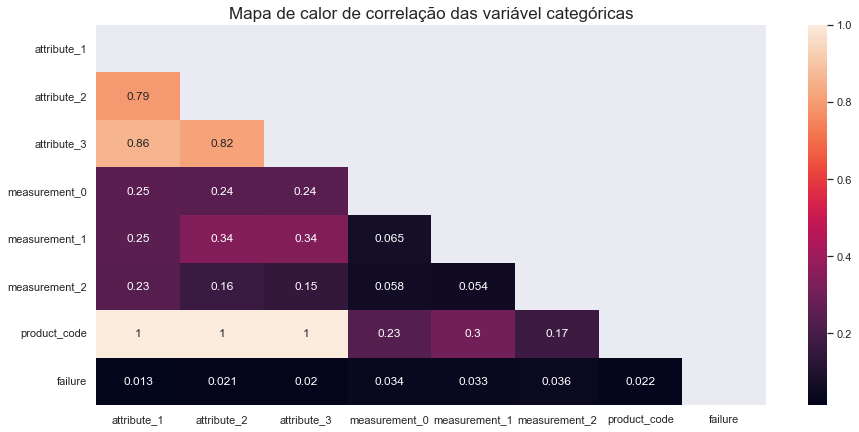

In [180]:
plt.figure(figsize=(15,7))

df         = df2_train[feature].astype(object)
df[target] = df2_train[target].astype(object)

corr = Ultil.generate_category_table(df)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask= mask). \
         set_title('Mapa de calor de correlação das variável categóricas', fontsize=17);

del df

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
  
Observamos que ao fazemos a transformação das variáveis do tipo interio para object melhoramos a correlação com a variável alvo. 
    
</div>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 3. Modelagem (baseline) </h1>    
</div>


In [181]:
seed      = 12359
df3_train = df2_train.copy().drop('id', axis=1)
df3_test  = df2_test.copy().drop('id', axis=1)

In [200]:
feature_cat = [col for col in df3_test.columns if df3_test[col].dtype in ["object", "int64"]]
feature_num = [col for col in df3_test.columns if col not in feature_cat]

In [214]:
feature_cat.remove('product_code')

## 3.1. Processamento

### 3.1.1. Pipeline

In [238]:
params = {'seed': seed,
          'n_jobs': -1,
          #'lambda_l2': 2,
          'num_leaves': 100,
          #'boosting': 'dart',
          #'bagging_freq': 10,        
          'learning_rate': 0.01,
          'objective': 'binary',        
          #'min_data_in_leaf': 40,
          #'num_boost_round': 1000,
          #'feature_fraction': 0.20,
          #'bagging_fraction': 0.50,        
          'metric': "binary_logloss"}

model_lgbm = LGBMClassifier(**params)
model_lr   = LogisticRegressionCV(random_state = 0,
                                  solver       = 'saga', 
                                  penalty      = 'elasticnet', 
                                  l1_ratios    = np.arange(0, 1, 11), 
                                  max_iter     = 10000)

In [239]:
# Preprocessing for categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, feature_num),
        ('cat', categorical_transformer, feature_cat)
    ])


pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_lgbm)
])

## 3.4. Validação Cruzada

In [240]:
X      = df3_train.drop(target, axis=1)
y      = df3_train[target]
X_test = df3_test.copy()  
groups = df3_train['product_code']

In [242]:
preds_oof  = np.zeros(len(df3_train))
preds_test = np.zeros(len(df3_test))

folds = GroupKFold(n_splits=5)

for fold_idx, (train_idx, val_idx) in enumerate(folds.split(X, y, groups)):
    
    x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    pipeline_lgbm.fit(x_train, y_train)
    
    val_preds = pipeline_lgbm.predict_proba(x_val)[:, 1]
    
    print("FOLD: {} - ROC-AUC: {:2.5f}".format(fold_idx+1, roc_auc_score(y_val, val_preds)))
    
    preds_test += pipeline_lgbm.predict_proba(X_test)[:, 1] / 5
    preds_oof[val_idx] = val_preds 
    
print()
print("OOF ROC-AUC:  {:2.5f}".format(roc_auc_score(y, preds_oof)))

FOLD: 1 - ROC-AUC: 0.56023
FOLD: 2 - ROC-AUC: 0.56869
FOLD: 3 - ROC-AUC: 0.57063
FOLD: 4 - ROC-AUC: 0.58157
FOLD: 5 - ROC-AUC: 0.57429

OOF ROC-AUC:  0.56966


In [ ]:
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_lr)
])

pipeline_lr.fit(X, y)
preds_test_lin = pipeline_lr.predict_proba(X_test)[:, 1]

print("OOF ROC-AUC:  {:2.5f}".format(roc_auc_score(y, preds_test_lin)))

In [ ]:
output = pd.DataFrame({'id': df_test.index, 'failure': ( (preds_test * 0.1) + (preds_test_lin * 0.9)) })
output.to_csv('submission.csv', index=False)

In [ ]:
def cross_val_model(model_, model_name_, X_, y_, X_test_, target_, scalers_, lb_, fold_=5, path_='',  
                    seed_=12359, feature_scaler_=None, print_report_=False, save_submission_=False):
    
    n_estimators = model_.get_params()['n_estimators']
             
    valid_preds     = {}
    taco            = 76 
    acc_best        = 0
   # col_prob        = y_.sort_values().unique()
    df_proba        = pd.DataFrame()
    feature_imp     = pd.DataFrame()
    test_preds      = []
    test_pred_proba = np.zeros((1, 1))
    preds           = []
    model           = []
    
    for i, scaler_ in enumerate(scalers_): 

        time_start = datetime.now()
        score      = []        
                
        if scaler_!=None:            
            string_scaler = str(scaler_)        
            string_scaler = string_scaler[:string_scaler.index('(')]
        else:
            string_scaler = None 
            
        y_pred_test = np.zeros(len(X_test_))

        folds = KFold(n_splits=fold_, shuffle=True, random_state=seed_)
        folds = StratifiedKFold(n_splits=fold_, shuffle=True, random_state=seed_)
        
        print('='*taco)
        print('Scaler: {} - n_estimators: {}'.format(string_scaler, n_estimators))
        print('='*taco)
        
        pred_test=0 
        
        for fold, (trn_idx, val_idx) in enumerate(folds.split(X_, y_, groups=y_)): 

            time_fold_start = datetime.now()

            # ---------------------------------------------------- 
            # Separar dados para treino 
            # ----------------------------------------------------     
            X_trn, X_val = X_.iloc[trn_idx], X_.iloc[val_idx]
            y_trn, y_val = y_.iloc[trn_idx], y_.iloc[val_idx] 
            
            # ---------------------------------------------------- 
            # Processamento 
            # ----------------------------------------------------     
            if scaler_!=None: 
                X_tst = X_test_.copy()
                if feature_scaler_!=None:                     
                    X_trn[feature_scaler_] = scaler_.fit_transform(X_trn[feature_scaler_])
                    X_val[feature_scaler_] = scaler_.transform(X_val[feature_scaler_])                      
                    X_tst[feature_scaler_] = scaler_.transform(X_tst[feature_scaler_])
                else:            
                    X_trn = scaler_.fit_transform(X_trn)
                    X_val = scaler_.transform(X_val)
                    X_tst = scaler_.transform(X_test_.copy())
                
            # ---------------------------------------------------- 
            # Treinar o modelo 
            # ----------------------------------------------------            
            model_.fit(X_trn, y_trn,
                       eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                       early_stopping_rounds = int(n_estimators*.1),
                       verbose               = False)
            
            # ---------------------------------------------------- 
            # Predição 
            # ----------------------------------------------------     
            y_pred_val_prob = model_.predict_proba(X_val, ntree_limit=model_.best_ntree_limit)[:,1]    
            y_pred_val      = (y_pred_val_prob>.5).astype(int)

            preds.append(model_.predict(X_tst))    
            
            pred_test += model_.predict_proba(X_tst)[:, 1] / folds.n_splits
                
            df_prob_temp    = pd.DataFrame(y_pred_val_prob)
            #y_pred_pbro_max = df_prob_temp.max(axis=1)

            df_prob_temp['fold']    = fold+1
            df_prob_temp['id']      = val_idx            
            df_prob_temp['y_val']   = y_val.values
            df_prob_temp['y_pred']  = y_pred_val            
            df_prob_temp['y_proba'] = y_pred_val_prob
            df_prob_temp['scaler']  = str(string_scaler)
                        
            # ---------------------------------------------------- 
            # Score 
            # ---------------------------------------------------- 
            acc   = metrics.accuracy_score(y_val, y_pred_val)
            auc   = metrics.roc_auc_score(y_val, y_pred_val_prob)
            f1    = metrics.f1_score(y_val, y_pred_val) 
            prec  = metrics.log_loss (y_val, y_pred_val)
            
            score.append(auc)     
            
            # ---------------------------------------------------- 
            # Feature Importance
            # ----------------------------------------------------             
            feat_imp = pd.DataFrame(index   = X_.columns,
                                    data    = model_.feature_importances_,
                                    columns = ['fold_{}'.format(fold+1)])

            feat_imp['auc_'+str(fold+1)] = auc
            feature_imp = pd.concat([feature_imp, feat_imp], axis=1)
            
            # ---------------------------------------------------- 
            # Print resultado  
            # ---------------------------------------------------- 
            time_fold_end = diff(time_fold_start, datetime.now())
            msg = '[Fold {}] AUC: {:2.5f} - F1-score: {:2.5f} - L. Loss: {:2.5f}  - {}'
            print(msg.format(fold+1, auc, f1, prec, time_fold_end))
            
            # ---------------------------------------------------- 
            # Salvar o modelo 
            # ---------------------------------------------------- 
            dic_model = {'scaler' : scaler_, 
                         'fold'   : fold+1, 
                         'model'  : model_ }
            
            model.append(dic_model)

        score_mean = np.mean(score) 
        score_std  = np.std(score)

        if score_mean > acc_best:     
            acc_best    = score_mean           
            model_best  = model_    
            scaler_best = scaler_

        time_end = diff(time_start, datetime.now())   

        print('-'*taco)
        print('[Mean Fold] AUC: {:2.5f} std: {:2.5f} - {}'.format(score_mean, score_std, time_end))
        print('='*taco)
        print()
               
        if save_submission_:
            name_file_sub  = model_name_ + '_' + str(i+1) + '_' + str(scaler_).lower()[:4] + '.csv'
            name_file_sub  = path_ + 'Data/submission/' + name_file_sub.format(score_mean)        
            df_sub         = df_submission.copy()
            df_sub[target] = pred_test
            df_sub.to_csv(name_file_sub, index=False)
            
        if print_report_:
            y_pred = df_prob_temp[df_prob_temp['scaler']==str(string_scaler)]['y_pred']
            y_vl   = df_prob_temp[df_prob_temp['scaler']==str(string_scaler)]['y_val']
            print(metrics.classification_report(y_vl,y_pred))

    print('-'*taco)
    print('Scaler Best: {}'.format(scaler_best))
    print('Score      : {:2.5f}'.format(acc_best))
    print('-'*taco)
    print()

    return model, df_prob_temp.sort_values(by=['scaler','id']) , feature_imp 

In [ ]:
%%time 

seed        = 12359
eval_metric = ['auc', 'error']                 
scalers     = [StandardScaler(), 
               QuantileTransformer(output_distribution='normal', random_state=0)]

params = {'objective'        : 'binary:logistic',   
          'eval_metric'      : eval_metric,
          'n_estimators'     : 1000,   
          'random_state'     : seed}

if torch.cuda.is_available():           
    params.update({'tree_method' : 'gpu_hist',                    
                   'predictor'   : 'gpu_predictor'})

model, df_proba, feature_imp = \
    cross_val_model(model_           = xgb.XGBClassifier(**params),
                    model_name_      = 'xgb_bs_vc_score_02_{:2.5f}',
                    X_               = X,
                    y_               = y,
                    X_test_          = X_test,
                    target_          = target,
                    scalers_         = scalers,
                    fold_            = 5, 
                    lb_              = None,
                    path_            = path,
                    seed_            = seed, 
                    feature_scaler_  = None, 
                    print_report_    = True, 
                    save_submission_ = True)
print()

## 3.5. Análise do Modelo 
Vamos fazer o treinamento novamente do melhor modelo, sendo que agora vamos utilizar a divisão de treino/teste, isto é, vamos o treino em um conjunto de dados e fazer a previsões em dados que o modelo não viu no treino. 

In [ ]:
scalers     = [QuantileTransformer(output_distribution='normal', random_state=0)]

model, df_proba, feature_imp = \
    cross_val_model(model_           = xgb.XGBClassifier(**params),
                    model_name_      = 'xgb_bs_vc_score_02_{:2.5f}',
                    X_               = X_train,
                    y_               = y_train,
                    X_test_          = X_test,
                    target_          = target,
                    scalers_         = scalers,
                    fold_            = 5, 
                    lb_              = None,
                    path_            = path,
                    seed_            = seed, 
                    feature_scaler_  = None, 
                    print_report_    = True, 
                    save_submission_ = False)
print()

### 3.5.1. Feature Importances  

In [ ]:
plt.figure(figsize=(15,12))
for fold, col in enumerate(feature_imp.filter(regex=r'fold').columns):            
    col_acc = 'auc_' + str(fold+1)
    df_fi = feature_imp.sort_values(by=col, ascending=False).reset_index().iloc[:15]
    df_fi = df_fi[['index', col, col_acc]]
    df_fi.columns = ['Feature', 'score', col_acc]
    plt.subplot(3,2, fold+1)
    sns.barplot(x='score', y='Feature', data=df_fi)    
    plt.title('Fold {} - score: {:2.5f}'.format(fold+1, df_fi[col_acc].mean()), 
              fontdict={'fontsize':18})    

plt.suptitle('Feature Importance XGB', y=1.05, fontsize=24);
plt.tight_layout(h_pad=3.0); 

### 3.5.2. Shap

In [ ]:
mdl = model[1]['model']
sc  = model[1]['scaler']

X_valid_sc = sc.transform(X_valid)#, columns=X_valid.columns)
y_pred_val = mdl.predict_proba(X_valid_sc)[:,1]
score      = metrics.roc_auc_score(y_valid, y_pred_val)

print('AUC em dados não viscto: {:2.5f}'.format(score))

In [ ]:
explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(X_valid_sc)

shap.summary_plot(shap_values, X_valid_sc, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_valid_sc, max_display=15)

### 3.1.1. Erro e  número de Estimadores

In [ ]:
for erro in eval_metric:
    plt.figure(figsize=(15,10))

    for i in range(len(model)):
        results     = model[i]['model'].evals_result() # merror
        ntree_limit = model[i]['model'].best_ntree_limit

        plt.subplot(2,3,i+1)
        plt.plot(results["validation_0"][erro], label="Treinamento")
        plt.plot(results["validation_1"][erro], label="Validação")

        plt.axvline(ntree_limit, 
                    color="gray", 
                    label="N. de árvore ideal {}".format(ntree_limit))

       # plt.xlabel('Número de árvores')
        plt.ylabel(erro)
        plt.legend();

    plt.suptitle('Performance XGB - {}'.format(erro), y=1.05, fontsize=24);
    plt.tight_layout(h_pad=3.0);

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Acima recuperamos as informações de treinamento do nosso modelo, podemos observar que o número de 1000 estimadores é mais que suficiente para o treinamento do modelo, já na predição utilizamos 536 estimadores que torna as predições mais performáticas, esse parametro pode ajuda na tunning do XGB.  
    
</div>

### 3.1.2. Previsão 

In [ ]:
scaler_tr  = model[1]['scaler']
model_tr   = model[1]['model']
X_valid_sc = pd.DataFrame(scaler_tr.transform(X_valid), columns=X_valid.columns)

y_pred_prob = model_tr.predict_proba(X_valid_sc.values, ntree_limit=model_tr.best_ntree_limit)[:,1]
y_pred      = (y_pred_prob >.5).astype(int)
auc         = metrics.roc_auc_score(y_valid, y_pred_prob)

print('AUC: {:2.5f}'.format(auc))

### 3.1.3. Matriz de Confusão

In [ ]:
def plot_cm(preds,true,ax=None):
    cm = confusion_matrix(preds.round(), true)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, colorbar=False, values_format = '.6g')
    plt.title('Confusion matrix \n')
    plt.grid(False)
    return disp

plot_cm(y_pred, y_valid);

In [ ]:
threshold = .47

y_pred_threshold     = (y_pred_prob>threshold).astype(int)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_pred_threshold)

plot_roc_curve(fpr, tpr, label="XGB")
plt.show()

print('AUC     : {:2.5f} '.format(metrics.roc_auc_score(y_valid, y_pred_prob) ))
print('F1-score: {:2.5f}'.format(metrics.f1_score(y_valid, y_pred)))
print('F1-score: {:2.5f} threshold({:2.2f})'.format(metrics.f1_score(y_valid, y_pred_threshold), threshold))

<div class="alert alert-info" role="alert"> 
  
CONCLUSÃO: <BR>
Agora temos uma noção do conjunto de dados para esse competição e uma linha de base com o classificador XGB, que se mostrou promissor nas submissões, obtive os sequintes resultados: 0.93628 e 0.93935 todos melhores que o treinamento do modelo, isso demostra que o modelo é robusto e teve uma boa generalização nos dados de teste que tem aproximadamente 29% dos dados, esse é um ponto importante que temos que considerar, pois no final da competição nosso modelo terá que ter um performance em todo o conjunto de dados. 
    
    
Os próximos passos são: <br>

- Feature Engineering     
Ainda há muito a explorar dentro do conjunto de dados, recomendo explorar as variáveis que se relacionam com a variável de destino. Com base nessas relações, podemos criar mais variáveis que são combinações de dois ou mais variaveis. Um exemplo seria a variável C que é formada pelas variáveis A x B. Além disso, a variável f_27 precisa ser examinada com mais detalhes. Pode haver informações importantes escondidas em todos essas variáveis aparentemente sem sentido; 
<br>
    
- Tunning de hyperparametros     
Neste notebook não nos aprofundamos no tunning de hyperparametro do classificado XGB, é outro ponto importante mesmo que o ganho seja pouco, o tunning faz com que os modelos se tornem mais robusto e qualquer ganho pode melhora a nosso colocação na competição;
    
   
    
</div>

In [ ]:
distribution shift python

https://medium.com/analytics-vidhya/practical-issues-in-data-science-part-2-distribution-shift-part-1-416754c01905


https://gsarantitis.wordpress.com/2020/04/16/data-shift-in-machine-learning-what-is-it-and-how-to-detect-it/


https://evidentlyai.com/blog/machine-learning-monitoring-data-and-concept-drift



cbo 

ocupacoes.com.br


Eduardo Mendes (DP) 


- https://reliability.readthedocs.io/en/latest/Quickstart%20for%20reliability.html
- https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/


Time Series Stationarity in Python 
https://analyzingalpha.com/check-time-series-stationarity-python

https://www.google.com/search?rlz=1C1GCEU_pt-BRBR822BR822&sxsrf=ALiCzsbYRIwkxC5bKGoJGfUeos_9V8i3sg:1657625131479&source=univ&tbm=isch&q=distribution+shift+python&fir=YJAHOwq1Gel19M%252CDFxRnIl2120C2M%252C_%253BL-FrVrCY9yMCDM%252CDFxRnIl2120C2M%252C_%253BK5wYnKPLGAuJwM%252C4Fm6oaqD6NEZqM%252C_%253BduJMFcMyz6s3bM%252C4Fm6oaqD6NEZqM%252C_%253B7WP6-xYQFOQUbM%252CDFxRnIl2120C2M%252C_%253BFKoyq_YZmk1LVM%252C2U-D892yiN4O0M%252C_%253BQetlyZx526Vi_M%252CyaCixvxhcT7nOM%252C_%253Bgm24d24EGTlMJM%252Cr4TLnkRzruuPgM%252C_%253B8Hoy97fA2lauGM%252CF36DyPQFIKFBEM%252C_%253BCvtHBxKM6JO24M%252CfKMhbZ3cw4ECkM%252C_&usg=AI4_-kTs6cB5Lh_cgqFa4mikiY1Yt7Dcmw&sa=X&ved=2ahUKEwiku4fpnvP4AhVQILkGHQWtBX0QjJkEegQIOhAC&biw=1522&bih=684&dpr=1.25#imgrc=Hk2RrMn0VpARhM&imgdii=vCQ8b_iefiQH8M



https://towardsdatascience.com/deep-dive-on-ml-techniques-for-feature-selection-in-python-part-1-3574269d5c69

https://towardsdatascience.com/paired-t-test-to-evaluate-machine-learning-classifiers-1f395a6c93fa

https://reliability.readthedocs.io/en/latest/Quickstart%20for%20reliability.html

https://github.com/shiguelita/ml_unsupervised_learning/blob/master/ml_unsupervised_learning.ipynb

https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/

https://realpython.com/k-means-clustering-python/



https://towardsdatascience.com/visualizing-your-embeddings-4c79332581a9
https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

https://towardsdatascience.com/deep-dive-on-ml-techniques-for-feature-selection-in-python-part-1-3574269d5c69


https://www.kaggle.com/code/azminetoushikwasi/intro-to-cross-validation-different-methods



    

In [ ]:
https://www.kaggle.com/code/ashaykatrojwar/feature-selection-iqr-outliers-eda
https://www.kaggle.com/code/cv13j0/tps-jun22-unsupervised-clustering-with-keras
https://www.kaggle.com/code/thedevastator/tps-the-fine-art-of-hyperparameter-tuning
https://www.kaggle.com/code/ambrosm/tpsjul22-gaussian-mixture-cluster-analysis
https://www.kaggle.com/code/ehekatlact/tps2207-ultra-fast-ensemble
https://www.kaggle.com/code/thedevastator/how-to-ensemble-clustering-algorithms-updated
https://www.kaggle.com/code/pourchot/simple-soft-voting
    
    

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

In [ ]:
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
pipe = Pipeline(steps=[('select', SelectKBest(k=2)), 
                       ('scaler', StandardScaler()), 
                       ('svc', SVC())])

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

In [ ]:
# https://realpython.com/k-means-clustering-python/
# https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam
# https://www.kaggle.com/code/gaganmaahi224/9-clustering-techniques-for-customer-segmentation/notebook
# https://www.kaggle.com/code/mehrdadsadeghi/tps-july2022-scaling-feature-selection
# https://www.kaggle.com/code/ashaykatrojwar/feature-selection-iqr-outliers-eda
# https://www.kaggle.com/code/m1y7k8/tps-jul-2022-clustering
# https://www.kaggle.com/code/adaubas/tps-jul22-lgbm-extratree-qda-soft-voting

In [ ]:
df1     = pd.read_csv(path + path_data + 'submission/submission.csv')
df2     = pd.read_csv(path + path_data + 'submission/submission_3.csv')


In [ ]:
df2['Pred'] = ((df1['Predicted'] + df2['Predicted'])/2)

In [ ]:
df2['Pred'] = df2['Pred'].astype(int)

In [ ]:
df2['Pred'] 

In [ ]:
df_submission['Predicted'] = df2['Pred'] 

In [ ]:
df_submission.to_csv('sub.csv', index=False)